In [26]:
import csv
import pandas as pd
import torch
import datetime
import torch.nn as nn
import torch.nn.functional as f
from sklearn.metrics import mean_squared_error
from numpy import vstack
from numpy import sqrt
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy



In [27]:
def player_position(positionfile):
    feature_set = pd.read_csv(positionfile) 
    df = pd.DataFrame(feature_set)
    # Remove ticks, time and player names, columns
    df.drop(df.columns[[0,1,2,3,6,9,12,15,18,21,24,27,30]], axis = 1, inplace = True)
    df = df.values
    final_player_pos = []
    for line in df:
        player_row = []
        for i in range (0,20,1): 
            if str(line[i]) == 'nan':
                line[i] = float(0.0);  
            player_row.append(line[i])      
        final_player_pos.append(player_row)
    return final_player_pos

def player_time(positionfile): 
    with open(positionfile, 'r') as read_obj:
        player_timestamps = []
        csv_reader = pd.read_csv(read_obj, header = None)
        df = pd.DataFrame(csv_reader)
        # Read column that has timestamps from replays
        player_timestamps = df.iloc[:, 2]
    return player_timestamps

def network_bytes_data(networkfile): 
    with open(networkfile, 'r') as read_obj:
        byte_data = []
        csv_reader = pd.read_csv(read_obj, header = None)
        df = pd.DataFrame(csv_reader)
        # Read column that has byte data
        byte_data = df.iloc[:, 1]
        final_byte_data = []
        for line in byte_data:
            if str(line) == 'nan':
                line = '00';       
            final_byte_data.append(line)

        df = pd.read_csv(networkfile, low_memory=False)
        max_value = df.iloc[:, 2].max()
        max_value = int(max_value)
    return final_byte_data, max_value

def network_bytes_time(networkfile): #'networkdataclean.csv'
    with open(networkfile, 'r') as read_obj:
        timestamps = []
        csv_reader = pd.read_csv(read_obj, header = None)
        df = pd.DataFrame(csv_reader)
        # Read column that has time data
        timestamps = df.iloc[:, 0]
    return timestamps


In [28]:
# Function to get tensors
def get_tensors(positionfile, networkfile):
    Validation_file = "NEWFILE_%s" %positionfile
    data_folder = Path("../CSGOreplaysfiles/")
    positionfile = data_folder / positionfile
    networkfile = data_folder / networkfile
    
    # Get network bytes data
    data, max_value = network_bytes_data(networkfile)
    # Array of final bytes data
    final_byte_data = []
    for byte_string in data:
        # Array of bytes from a row
        byte_row = []
        byte_string = str(byte_string)
        
        # Convert byte data from hex to numeric values
        for i in range(0, len(byte_string),3):  
            pair = byte_string[i:i+2]
            bit = int(pair, 16)
            bit = float(bit)
            bit /= 240.0
            byte_row.append(bit) 
        # Fill in empty slots  
        if len(byte_row) < max_value:
                for j in range(max_value - len(byte_row)):
                    byte_row.append(float(0.0))   
        # Add byte data after conversion to final bytes data array 
        final_byte_data.append(byte_row)
    
    # Get timestamps from game replays after parsing
    player_pos_time = player_time(positionfile)
    # Get player position from game replays after parsing
    player_pos = player_position(positionfile)
    # Get timestamps from network data file
    timestamps = network_bytes_time(networkfile)

    # Array to store bytes as tensor
    tensorbyte = []
    # Array to store players' positions as tensors
    tensorposition = []
    # Array to store timestamp as verification
    time =[]
    time_player = []
    # Array to store timestamps from replays file after parsing
    player_time_array = []
    # Array to store timestamps from network data
    network_time_array = [] 

    # Read timestamps from game replays after parsing file to array
    for positions in player_pos_time:   
        if positions[11:13].isnumeric():
            hr=int(positions[11:13])      
        if positions[14:16].isnumeric():
            mins = int(positions[14:16])
        if positions[17:19].isnumeric():    
            sec = int(positions[17:19])
        if positions[20:23].isnumeric():    
            mill = int(positions[20:23])
        
        datetime_player = datetime.time(hr, mins, sec, mill)
        datetime_player = datetime.datetime.combine(datetime.date(1, 1, 1), datetime_player)
        player_time_array.append(datetime_player)
    
    # Read timestamps from network data file to array   
    for timestamp in timestamps:
        hr = int(timestamp[13:15])
        mins = int(timestamp[16:18])
        sec = int(timestamp[19:21])
        mill = int(timestamp[22:25])
        datetime_key = datetime.time(hr, mins, sec, mill)
        datetime_key = datetime.datetime.combine(datetime.date(1, 1, 1),datetime_key)
        network_time_array.append(datetime_key)
    it = 0
    count = 0
    # If Wireshark started receiving info before match starts, skip these rows
    while network_time_array[count] < player_time_array[0]:
        count+=1
    # If network timestamp is bigger than player timsetamps,
    while count < len(network_time_array) and it < len(player_time_array):
        if network_time_array[count] >= player_time_array[it]:
            # Recall and use the previous network timestamp 
            tensorbyte.append(final_byte_data[count-1])
            tensorposition.append(player_pos[it])
            time.append(network_time_array[count-1])
            time_player.append(player_time_array[it])
            # Move to next index
            it += 1
            while network_time_array[count] >= player_time_array[it] :
                it+=1
        count+=1
        

    # Create tensors from network byte data
    x = torch.FloatTensor(tensorbyte)
    # Create tensors from players' position data
    y = torch.FloatTensor(tensorposition)
    # Normalize these values for NN model
    y = torch.nn.functional.normalize(y)
    
    
    # Write network bytes, players' positions and timestamps to a file for verification
    with open(data_folder/Validation_file, "w") as csvfile:
        writer = csv.writer(csvfile)
        for value in range(len(tensorbyte)):
            writer.writerow([tensorbyte[value], y[value], tensorposition[value],time[value], time_player[value]])
    return x,y,time, max_value

In [29]:
networkdatafile = "july16_networkdata_clean.csv"
replaydatafile = "july16.csv"
x,y,time,max_value = get_tensors(replaydatafile, networkdatafile) 
print("Tensor size of network samples: ",x.size())
print("Tensor size of players' position data: ", y.size())
print(len(time))
print(max_value)

Tensor size of network samples:  torch.Size([15485, 1280])
Tensor size of players' position data:  torch.Size([15485, 20])
15485
1280


In [30]:
print("Total samples from data set from network file: ", x.size()[0])
print("Number of feature from each sample: ", x.size()[1])
print("Total samples from data set from players' positions file: ", y.size()[0])
print("Number of feature from each sample: ", y.size()[1])

Total samples from data set from network file:  15485
Number of feature from each sample:  1280
Total samples from data set from players' positions file:  15485
Number of feature from each sample:  20


In [31]:
def prepare_data(x, y):
    idx = torch.randperm(x.size()[0])
    split = int(x.size()[0] * 0.80)
    trainx = x[idx[     :split], :]
    valx =   x[idx[split:     ], :]
    trainy = y[idx[     :split], :]
    valy =   y[idx[split:     ], :]
    return trainx, valx, trainy, valy

In [32]:
class Model(nn.Module):
    def __init__(self, max_value): 
        super(Model, self).__init__()
        first_layer = round(max_value*66/100)
        self.fc1 = nn.Linear(max_value,first_layer)
        second_layer = round(first_layer*66/100)
        self.fc2 = nn.Linear(first_layer, second_layer)
        third_layer = round(second_layer*66/100)
        self.fc3 = nn.Linear(second_layer, third_layer)
        self.fc4 = nn.Linear(third_layer, 20)

    def forward(self, x):
        x = f.leaky_relu(self.fc1(x))
        x = f.leaky_relu(self.fc2(x))
        x = f.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [33]:
def train(m, x, y):
    print("\nTraining in progress...")
    opt = torch.optim.Adam(m.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    Loss_list = []

    for i in range(100):
        model_result  = m(x) #yhat
        opt.zero_grad()
        loss = criterion(model_result , y)
        loss.backward()
        opt.step()
        Loss_list.append(loss / (len(x)))
        
    print('Finished Training Trainset')
    x2 = range(0, 100)
    y2 = Loss_list
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Loss vs. epoches')
    plt.ylabel('Loss')
    plt.savefig('ipynb_accuracy_loss.jpg')  
    plt.show()
    

def evaluation(model, x, y):
    predictions, actuals = list(), list()
    print("Evaluating Model...")
    for i in enumerate(x):
        yhat = model(x)
        yhat = yhat.detach().numpy()
        actual = y.numpy() 
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    mse = mean_squared_error(actuals, predictions)
    return mse

In [34]:
trainx, valx, trainy, valy = prepare_data(x, y)
print("Training data samples (network bytes): ", trainx.size())
print("Training data lables (real player positions): ", trainy.size())
print("Testing data samples (network bytes): ", valx.size())
print("Testing data labels (real player positions): ", valy.size())

"""torch.Size([12382, 1280])
torch.Size([12382, 20])
torch.Size([3096, 1280])
torch.Size([3096, 20])"""



Training data samples (network bytes):  torch.Size([12388, 1280])
Training data lables (real player positions):  torch.Size([12388, 20])
Testing data samples (network bytes):  torch.Size([3097, 1280])
Testing data labels (real player positions):  torch.Size([3097, 20])


'torch.Size([12382, 1280])\ntorch.Size([12382, 20])\ntorch.Size([3096, 1280])\ntorch.Size([3096, 20])'

In [35]:
model = Model(max_value)

Finished Training Trainset


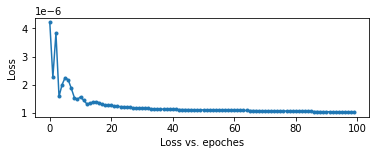

In [36]:
train(model, trainx, trainy)

In [37]:
mse = evaluation(model, valx, valy)
print('MSE: %.3f, RMSE: %.3f' % (mse, sqrt(mse)))
#MSE: 0.013, RMSE: 0.115

Evaluating Model...


In [ ]:
def predict(x, y, time, model, filereal, filepredict):
    filereal = data_folder / filereal
    filepredict = data_folder / filepredict
    rows = x.clone().detach().requires_grad_(True)
    yhat = model(rows)
    y = y.detach().numpy()
    yhat = yhat.detach().numpy()
    idx = 20
    field_names = ['Player1_x','Player1_y','Player2_x','Player2_y','Player3_x','Player3_y',
                    'Player4_x','Player4_y','Player5_x','Player5_y','Player6_x','Player6_y',
                    'Player7_x','Player7_y', 'Player8_x','Player8_y', 'Player9_x','Player9_y','Player10_x','Player10_y', 'Time']
    with open(filereal, 'w', newline='') as resultFile:
        wr = csv.writer(resultFile)
        wr.writerow(field_names)
        df = pd.DataFrame(y)
        df.insert(loc=idx, column='Time', value=time)
        df = numpy.array(df)
        mywriter = csv.writer(resultFile, delimiter=',')
        mywriter.writerows(df)
        
    with open(filepredict, 'w', newline='') as resultFile:
        wr = csv.writer(resultFile)
        wr.writerow(field_names)
        df = pd.DataFrame(yhat)
        
        df.insert(loc=idx, column='Time', value=time)
        df = numpy.array(df)
        mywriter = csv.writer(resultFile, delimiter=',')
        mywriter.writerows(df)

In [ ]:
data_folder = Path("../CSGOreplaysfiles/")
realfile = "real_"+ replaydatafile
predictfile = "predict_"+ replaydatafile

results = predict(x, y, time, model,realfile, predictfile)



In [ ]:
def plotfiles(file, type):
    df = pd.read_csv(file)
    plt.figure(figsize=(4,3))
    plt.tick_params(labelsize=14)
    mpl.style.use('seaborn')
    plt.xlim(-.4, .4)
    plt.ylim(-.2, 0.5)    
    Titlename = "%s positions" %type
    plt.title(Titlename, fontsize = 20)
    plt.plot(df.Player1_x,df.Player1_y, '.',  markersize = 10, label = "Player1" )
    plt.plot(df.Player2_x,df.Player2_y, '.', markersize = 10,label = "Player2")
    plt.plot(df.Player3_x,df.Player3_y, '.', markersize = 10,label = "Player3")
    plt.plot(df.Player4_x,df.Player4_y, '.', markersize = 10,label = "Player4")
    plt.plot(df.Player5_x,df.Player5_y, '.', markersize = 10,label = "Player5")
    plt.plot(df.Player6_x,df.Player6_y, '.', markersize = 10,label = "Player6")
    plt.plot(df.Player7_x,df.Player7_y, '.', markersize = 10,label = "Player7")
    plt.plot(df.Player8_x,df.Player8_y, '.', markersize = 10,label = "Player8")
    plt.plot(df.Player9_x,df.Player9_y, '.', markersize = 10,label = "Player9")
    plt.plot(df.Player10_x,df.Player10_y, '.', markersize = 10,label = "Player10")
    plt.legend(bbox_to_anchor=(1, 1), fontsize = 13, loc='upper left', borderaxespad=0.)
    
    namefig = "%s.png" %Titlename
    plt.savefig(namefig, bbox_inches='tight')  
    plt.show()

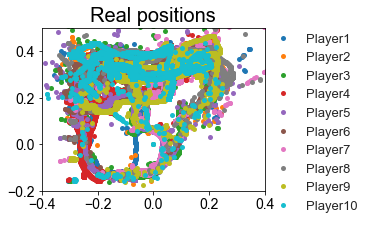

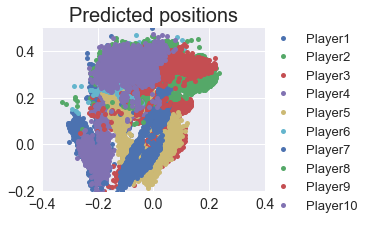

In [ ]:
plotfiles(data_folder/realfile, "Real")
plotfiles(data_folder/predictfile, "Predicted")


In [ ]:
def get_randomsamples(realfile,predictedfile,num_sample):
    sample_realfile = "sample_%s" %realfile
    sample_realfile = data_folder/sample_realfile
    sample_predictedfile = "sample_%s" %predictedfile
    sample_predictedfile = data_folder/ sample_predictedfile
    realfile = data_folder / realfile
    predictedfile = data_folder / predictedfile
    csv_reader_real = pd.read_csv(realfile, skiprows=[1] ,header = None)
    df_real = pd.DataFrame(csv_reader_real)
    csv_reader_predict = pd.read_csv(predictedfile, skiprows=[1] , header = None)
    df_predict = pd.DataFrame(csv_reader_predict)
    y = df_real.sample(num_sample)
    field_names = ['Player1_x','Player1_y','Player2_x','Player2_y','Player3_x','Player3_y',
                    'Player4_x','Player4_y','Player5_x','Player5_y','Player6_x','Player6_y',
                    'Player7_x','Player7_y', 'Player8_x','Player8_y', 'Player9_x','Player9_y','Player10_x','Player10_y', 'Time']
    
    with open(sample_realfile, 'w', newline='') as resultFile:
        wr = csv.writer(resultFile)
        wr.writerow(field_names)
        df_real = numpy.array(y)
        mywriter = csv.writer(resultFile, delimiter=',')
        mywriter.writerows(df_real)
   
    with open(sample_predictedfile, 'w', newline='') as resultFile:
        wr = csv.writer(resultFile)
        wr.writerow(field_names)
        sample_line = []
        time_label = []
        
        for i in range (0,3,1):
            value = y.iloc[i, 20]
            line =0
            while line < len(df_predict):
                if str(value) == str(df_predict.iloc[line, 20]):
                    sample_line.append(df_predict.iloc[line,:])
                    time_label.append(value)
                line+=1
        sample_line = pd.DataFrame(sample_line)
        sample_line = numpy.array(sample_line)
        mywriter = csv.writer(resultFile, delimiter=',')
        mywriter.writerows(sample_line)
        eachtime = ""
        for positions in time_label:   
            each = positions[11:19]
            eachtime += "_"+each   
        eachtime = eachtime[1:]
    return sample_realfile, sample_predictedfile,eachtime

In [ ]:
sample_realfile, sample_predictedfile,eachtime = get_randomsamples(realfile,predictfile,3)
print(eachtime)

12:35:36_12:37:02_12:40:02


In [ ]:
def connectpoints(real,predict,sample, playerx, playery):
        x1, x2 = real[sample][playerx], predict[sample][playerx]
        y1, y2 = real[sample][playery], predict[sample][playery]
        plt.plot([x1,x2],[y1,y2],'k-', ls = '--', alpha = 0.4)

In [ ]:
def plotsamples(filereal, filepredict, Time):
    df = pd.read_csv(filereal)
    dff = pd.read_csv(filepredict)
    # Read column that has timestamps from replays
    plt.figure(figsize=(4,3))
    plt.tick_params(labelsize=14)
    df = df.drop(['Time'],axis=1)
    dff = dff.drop(['Time'],axis=1)
    mpl.style.use('seaborn')
    plt.xlim(-.4, .4)
    plt.ylim(-.2, 0.5)
    time = Time.replace(":", "_")
    
    Title = "Real vs predicted positions:\n %s \n  Players 1-5" %Time
    plt.title(Title, fontsize = 18) 
    plt.plot(df.Player1_x,df.Player1_y, '#00FFFF', marker = '.', markersize = 10, label = "Player1" )
    plt.plot(df.Player2_x,df.Player2_y, '#9ACD32', marker = '.', markersize = 10, label = "Player2")
    plt.plot(df.Player3_x,df.Player3_y, '#A52A2A', marker = '.', markersize = 10, label = "Player3")
    plt.plot(df.Player4_x,df.Player4_y, '#D2B48C', marker = '.', markersize = 10, label = "Player4")
    plt.plot(df.Player5_x,df.Player5_y, '#FF7F50', marker = '.', markersize = 10, label = "Player5")
    
    
    plt.plot(dff.Player1_x,dff.Player1_y, '#13EAC9', marker = '*', markersize = 10, label = "Player1-Predict" )
    plt.plot(dff.Player2_x,dff.Player2_y, '#BBF90F', marker = '*', markersize = 10, label = "Player2-Predict")
    plt.plot(dff.Player3_x,dff.Player3_y, '#653700', marker = '*', markersize = 10, label = "Player3-Predict")
    plt.plot(dff.Player4_x,dff.Player4_y, '#D1B26F', marker = '*', markersize = 10, label = "Player4-Predict")
    plt.plot(dff.Player5_x,dff.Player5_y, '#FC5A50', marker = '*', markersize = 10, label = "Player5-Predict")

    df = pd.DataFrame(df)
    df = df.values 
    dff = pd.DataFrame(dff)
    dff = dff.values            

    for sample in range (0,3,1):
        for playerx in range (0, 9, 2):
            playery = playerx+1
            connectpoints(df,dff,sample,playerx,playery)
    
    plt.legend(bbox_to_anchor=(1, 1),fontsize = 13, loc='upper left', borderaxespad=0.)
    
    namefig = "%s Real vs predicted positions Players 1-5.png" %time
    plt.savefig(namefig, bbox_inches='tight') 
    plt.show()

    df = pd.read_csv(filereal)
    dff = pd.read_csv(filepredict)
    # Read column that has timestamps from replays
    plt.figure(figsize=(4,3))
    plt.tick_params(labelsize=14)
    df = df.drop(['Time'],axis=1)
    dff = dff.drop(['Time'],axis=1)
    mpl.style.use('seaborn')
    plt.xlim(-.4, .4)
    plt.ylim(-.2, 0.5)
    Title = "Players 6-10"
    plt.title(Title, fontsize = 18) 
    plt.plot(df.Player6_x,df.Player6_y, '#DC143C', marker = '.', markersize = 10, label = "Player6")
    plt.plot(df.Player7_x,df.Player7_y, '#FF00FF', marker = '.', markersize = 10, label = "Player7")
    plt.plot(df.Player8_x,df.Player8_y, '#FFD700', marker = '.', markersize = 10, label = "Player8")  
    plt.plot(df.Player9_x,df.Player9_y, '#FFC0CB', marker = '.', markersize = 10, label = "Player9")    
    plt.plot(df.Player10_x,df.Player10_y, '#008080', marker = '.', markersize = 10, label = "Player10")

    plt.plot(dff.Player6_x,dff.Player6_y, '#8C000F', marker = '*', markersize = 10, label = "Player6-Predict")
    plt.plot(dff.Player7_x,dff.Player7_y, '#ED0DD9', marker = '*', markersize = 10, label = "Player7-Predict")
    plt.plot(dff.Player8_x,dff.Player8_y, '#DBB40C', marker = '*', markersize = 10, label = "Player8-Predict") 
    plt.plot(dff.Player9_x,dff.Player9_y, '#FF81C0', marker = '*', markersize = 10, label = "Player9-Predict")  
    plt.plot(dff.Player10_x,dff.Player10_y, '#029386', marker = '*', markersize = 10, label = "Player10-Predict")
        
    df = pd.DataFrame(df)
    df = df.values 
    dff = pd.DataFrame(dff)
    dff = dff.values 

    for sample in range (0,3,1):
        for playerx in range (10, 19, 2):
            playery = playerx+1
            connectpoints(df,dff,sample,playerx,playery)
    
    plt.legend(bbox_to_anchor=(1, 1),fontsize = 13, loc='upper left', borderaxespad=0.)
    
    namefig = "%s Real vs predicted positions Players 6-10.png" %time
    plt.savefig(namefig,bbox_inches='tight') 
    plt.show()

 

<ipython-input-18-506c2a0204cd>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([x1,x2],[y1,y2],'k-', ls = '--', alpha = 0.4)


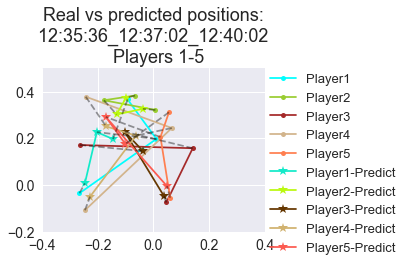

<ipython-input-18-506c2a0204cd>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([x1,x2],[y1,y2],'k-', ls = '--', alpha = 0.4)


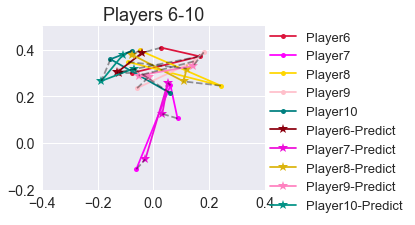

In [ ]:
plotsamples(data_folder/sample_realfile,data_folder/ sample_predictedfile, eachtime)  